<a href="https://colab.research.google.com/github/BalintKomjati/infinite-loop/blob/main/stable-diffusion-2-infinite-zoom-out/infinite_zoom_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a notebook prepared to quickly and easily generate infinite zoom videos like e.g. this one:

In [25]:
#@markdown CHECK TYPE OF GPU AND VRAM AVAILABLE   <br>
#@markdown The notebook should work fine with the Tesla T4 GPU + 16 GB VRAM available (but to a limited extend) in the free colab tier. <br>
#@markdown If this drops an error you need go: Runtime / Change runtime type and pick Hardvare accelarator = GPU and GPU class = Standard.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 5789 MiB


In [ ]:
#@markdown SET UP ENVIRONMENT

print("1/3: Install missing libraries")
%pip install -qq transformers scipy ftfy accelerate
%pip install -qq --upgrade diffusers[torch]

print("2/3: Load necessary libraries")
import PIL
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import random
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from IPython.display import clear_output

print("3/3: Define helper functions")
def write_video(file_path, frames, fps, reversed = True):
  """
  Writes frames to an mp4 video file
  :param file_path: Path to output video, must end with .mp4
  :param frames: List of PIL.Image objects
  :param fps: Desired frame rate
  :param reversed: if order of images to be reversed (default = True)
  """
  if reversed == True:
    frames.reverse()

  w, h = frames[0].size
  fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
  #fourcc = cv2.VideoWriter_fourcc(*'avc1')
  writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

  for frame in frames:
      np_frame = np.array(frame.convert('RGB'))
      cv_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2BGR)
      writer.write(cv_frame)

  writer.release() 

def image_grid(imgs, rows, cols):
  assert len(imgs) == rows*cols

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

def shrink_and_paste_on_blank(current_image, STEPSIZE):
  """
  Decreases size of current_image by STEPSIZE pixels from each side,
  then adds a STEPSIZE width transparent frame, so that the image the function returns
  returns is the same size as the input. 
  :param current_image: input image to transform
  :param STEPSIZE: width in pixels to shrink from each side
  """

  height = current_image.height
  width = current_image.width

  #shrink down by STEPSIZE
  prev_image = current_image.resize((height-2*STEPSIZE,width-2*STEPSIZE))
  prev_image = prev_image.convert("RGBA")
  prev_image = np.array(prev_image)

  #create blank non-transparent image
  blank_image = np.array(current_image.convert("RGBA"))*0
  blank_image[:,:,3] = 1

  #paste shrinked onto blank
  blank_image[STEPSIZE:height-STEPSIZE,STEPSIZE:width-STEPSIZE,:] = prev_image
  prev_image = Image.fromarray(blank_image)

  return prev_image





In [ ]:
#@markdown DOWNLOAD SD MODEL AND SET UP DIFFUSION PIPELINE <br><br>
#@markdown Pick your favourite inpainting model:
model_id = "stabilityai/stable-diffusion-2-inpainting" #@param
pipe = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
def dummy(images, **kwargs):
    return images, False
pipe.safety_checker = dummy
pipe.enable_attention_slicing() #This is useful to save some memory in exchange for a small speed decrease.

g_cuda = torch.Generator(device='cuda')  

  0%|          | 0/20 [00:00<?, ?it/s]

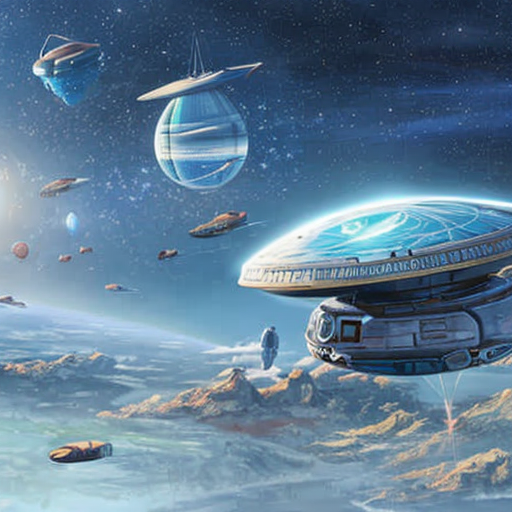

In [28]:
#@markdown FIND A GOOD CONCEPT FOR YOUR VIDEO: <br>
#@markdown (Image output of this block will be the last image of the video)

prompt = "A dream of a distant galaxy with spacecrafts, concept art, matte painting, HQ, 4k" #@param
negative_prompt = "blur, blurred, frame, ugly, low quality" #@param

#@markdown Number of initial example images to generate:
num_init_images = 1 #@param
#@markdown Random seed (arbitrary input to make the initial image generation deterministic):
seed = 1234 #@param
#@markdown  The number of denoising steps (Higher number usually lead to a higher quality image at the expense of slower inference):
num_inference_steps = 20 #@param
#@markdown Guidance scale defines how closely generated images to be linked to the text prompt:
guidance_scale = 8 #@param
#@markdown Heigth (and width) of the images in pixels (= resolution of the video generated in the next block, has to be divisible with 8):
height = 512 #@param
width = height 

current_image = PIL.Image.new(mode="RGBA", size=(height, width))
mask_image = np.array(current_image)[:,:,3] 
mask_image = Image.fromarray(255-mask_image).convert("RGB")
current_image = current_image.convert("RGB")

init_images =  pipe(prompt=prompt*num_init_images,
                    negative_prompt=negative_prompt*num_init_images,
                    image=current_image,
                    guidance_scale = guidance_scale,
                    height = height,
                    width = width, 
                    generator = g_cuda.manual_seed(seed),
                    mask_image=mask_image, 
                    num_inference_steps=num_inference_steps)[0]


image_grid(init_images, rows=1, cols=num_init_images)

We shrink the init image from the previous block and outpaint its outer frame using the same concept defined above (e.g. prompt, negative prompt, inference steps) but with a different seed. To generate an "inifinte zoom" video this is repeated **NUMFRAMES** times and then rendered in reversed order.  
  
To keep the outpainted part coherent and full of new content its width has to be relatively large (e.g. **STEPSIZE** = 128 pixels if resolution is 512*512). 
   
This on the other hand means that the generated video would be too fast and aestetically unpleasant. To slow down and smoothen the video we generate **num_interpol_frames** additional images between outpainted images using simple "interpolation".    

Notes:    

 - Length of the video is proportional to NUMFRAMES * num_interpol_frames.   
 - The time to generate the video is proportional to NUMFRAMES.  
 - On a T4 GPU it takes about ~7 minutes to generate the video of width = 512, num_inference_steps = 20, NUMFRAMES = 100. With fps = 24 and num_interpol_frames = 24 the video will be about 1:40 minutes long.


In [29]:
#@markdown GENERATE VIDEO:  <br> <br>

#@markdown Pick an image from the previous block for your video: <br> (This is only relevant if num_init_images > 1)
image_num_selected = 1 #@param
if num_init_images == 1:
  image_num_selected = 0
else:
  image_num_selected = image_num_selected - 1
#@markdown Number of outpainting steps:
NUMFRAMES = 5 #@param
#@markdown Width of the border in pixels to be outpainted during each step:
#@markdown <br> (make sure: STEPSIZE < image resolution / 2)
STEPSIZE = 128 #@param
#@markdown Number of frames to be interpolated between each outpainting step:
num_interpol_frames = 24 #@param 

current_image = init_images[image_num_selected]
all_frames = []
all_frames.append(current_image)

for i in range(NUMFRAMES):
  print('Generating image: ' + str(i+1) + ' / ' + str(NUMFRAMES))

  prev_image_fix = current_image

  prev_image = shrink_and_paste_on_blank(current_image, STEPSIZE)

  current_image = prev_image

  #create mask (black image with white STEPSIZE width edges)
  mask_image = np.array(current_image)[:,:,3] 
  mask_image = Image.fromarray(255-mask_image).convert("RGB")

  #inpaint
  current_image = current_image.convert("RGB")
  images = pipe(prompt=prompt,
                negative_prompt=negative_prompt,
                image=current_image,
                guidance_scale = guidance_scale,
                height = height,
                width = width, 
                #generator = g_cuda.manual_seed(seed), #this makes the whole thing deterministic but the output less exciting
                mask_image=mask_image, 
                num_inference_steps=num_inference_steps)[0]
  current_image = images[0]
  current_image.paste(prev_image, mask=prev_image)

  #zoom and crop to create interpolated frames between 2 inpainted frames
  for j in range(num_interpol_frames - 1):
    interpol_image = current_image
    pix = round(
        (1- ( 1-2*STEPSIZE/height )**( 1-(j+1)/num_interpol_frames ) )*height/2 
        )
    interpol_image = interpol_image.crop((pix,
                                          pix,
                                          width - pix,
                                          height - pix))

    interpol_image = interpol_image.resize((height, width))

    #fix blur in the middle:
    pix2 = round((height - (height - 2*STEPSIZE)*height/(height-2*pix))/2)
    prev_image_fix_crop = shrink_and_paste_on_blank(prev_image_fix, pix2)
    interpol_image.paste(prev_image_fix_crop, mask = prev_image_fix_crop)

    all_frames.append(interpol_image)

  all_frames.append(current_image)
  clear_output(wait=True)

Generating image: 5 / 5


  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
#@markdown RENDER THE GENERATED FRAMES INTO AN MP4 VIDEO.
video_file_name = "infinite_zoom_out" #@param
fps = 24 #@param
write_video(video_file_name + ".mp4", all_frames, fps)
#@markdown Once block is finished, download your video from the "Files" folder menu on the left (/content/video_file_name.mp4).

In [ ]:
#@markdown CHECK SOME (equally spaced) FRAMES OF THE VIDEO:
num_of_frames_to_chk = 4 #@param
num_of_frames_to_chk = min(num_of_frames_to_chk, len(all_frames))
idx = np.round(np.linspace(0, len(all_frames) - 1, num_of_frames_to_chk)).astype(int)
image_grid(list(all_frames[i] for i in idx), rows = 1, cols = num_of_frames_to_chk)
#@markdown (This is relatively slow but still faster in some cases then to download the complete video in the previous block)


Backlog of potential improvements (contributions are welcome):

 - Video to drift between prompts (now uses the same prompt for all images with different seed)
 - Make video more realistic and less like a hallucination ...
 - Change movement of the camera during video (e.g. turns in any direction)
 - Generate video in non-cubic resolution (now only cubic is possible)
